In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
from sklearn.metrics import mean_squared_error, mean_absolute_error

<b> Fetch the VIX1D and SPX data <b>

In [3]:
API_KEY = ""

# Set the parameters for the API request
sp500_ticker = "SPY"
vix1d_ticker = "I:VIX1D"
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Format dates for the API request
start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")

def get_data(ticker, start_date, end_date, multiplier=5, timespan='minute'):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={API_KEY}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json().get('results', [])
        return pd.DataFrame(data)
    else:
        print(f"Error fetching data for {ticker}: {response.status_code}")
        return None

def fetch_data_in_chunks(ticker, start_date, end_date, chunk_size=7):
    all_data = pd.DataFrame()
    current_start = start_date
    
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=chunk_size), end_date)
        print(f"Fetching data from {current_start} to {current_end}")
        chunk_data = get_data(ticker, current_start.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d"))
        
        if chunk_data is not None and not chunk_data.empty:
            all_data = pd.concat([all_data, chunk_data])
        
        current_start = current_end + timedelta(days=1)
    
    return all_data

# Fetch data in chunks for SPY and VIX1D
sp500_data = fetch_data_in_chunks(sp500_ticker, start_date, end_date)
vix1d_data = fetch_data_in_chunks(vix1d_ticker, start_date, end_date)

Fetching data from 2023-09-20 21:58:53.630901 to 2023-09-27 21:58:53.630901
Fetching data from 2023-09-28 21:58:53.630901 to 2023-10-05 21:58:53.630901
Fetching data from 2023-10-06 21:58:53.630901 to 2023-10-13 21:58:53.630901
Fetching data from 2023-10-14 21:58:53.630901 to 2023-10-21 21:58:53.630901
Fetching data from 2023-10-22 21:58:53.630901 to 2023-10-29 21:58:53.630901
Fetching data from 2023-10-30 21:58:53.630901 to 2023-11-06 21:58:53.630901
Fetching data from 2023-11-07 21:58:53.630901 to 2023-11-14 21:58:53.630901
Fetching data from 2023-11-15 21:58:53.630901 to 2023-11-22 21:58:53.630901
Fetching data from 2023-11-23 21:58:53.630901 to 2023-11-30 21:58:53.630901
Fetching data from 2023-12-01 21:58:53.630901 to 2023-12-08 21:58:53.630901
Fetching data from 2023-12-09 21:58:53.630901 to 2023-12-16 21:58:53.630901
Fetching data from 2023-12-17 21:58:53.630901 to 2023-12-24 21:58:53.630901
Fetching data from 2023-12-25 21:58:53.630901 to 2024-01-01 21:58:53.630901
Fetching dat

<b> Plot the Realized Volatility and VIX1D daily <b>

C:\Users\Thani\AppData\Local\Temp\ipykernel_24868\1945012877.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_realized_volatility = sp500_data.groupby('date').apply(calculate_realized_volatility)


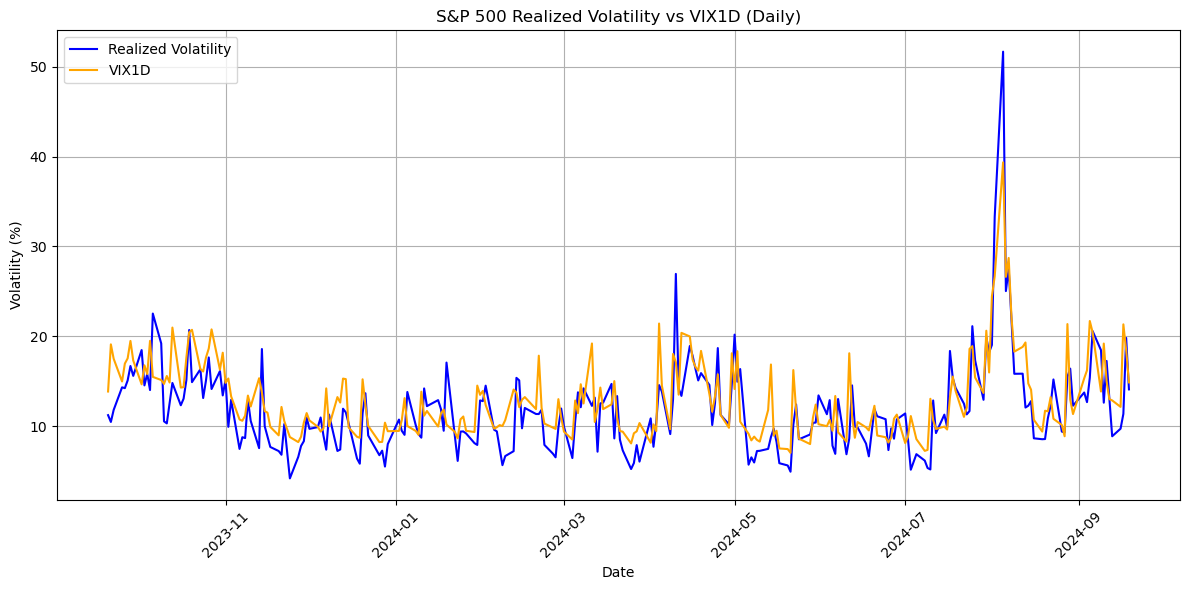

Mean Squared Error (MSE): 12.0992
Mean Absolute Error (MAE): 2.6579
Mean Absolute Percentage Error (MAPE): 25.96%


<Figure size 640x480 with 0 Axes>

In [5]:
if sp500_data is not None and vix1d_data is not None:
    # Calculate the log difference of closing prices (log returns)
    sp500_data['timestamp'] = pd.to_datetime(sp500_data['t'], unit='ms')
    sp500_data['c_log_diff'] = np.log(sp500_data['c']) - np.log(sp500_data['c'].shift(1))

    # Define a function to calculate realized volatility using the c_log_diff method
    def calculate_realized_volatility(df):
        """
        Calculate realized volatility for each day using log differences.
        """
        realized_vol = (df['c_log_diff'] ** 2).sum()  # Sum of squared log differences
        realized_vol = np.sqrt(realized_vol) * 100 * np.sqrt(252)  # Annualizing the volatility
        return realized_vol
    
    # Add a column for 'date' to group by
    sp500_data['date'] = sp500_data['timestamp'].dt.date

    # Group by each trading day and calculate daily realized volatility
    daily_realized_volatility = sp500_data.groupby('date').apply(calculate_realized_volatility)
    daily_realized_volatility = pd.DataFrame(daily_realized_volatility, columns=['realized_volatility'])

    # Process VIX1D data
    vix1d_data['timestamp'] = pd.to_datetime(vix1d_data['t'], unit='ms')
    vix1d_data['date'] = vix1d_data['timestamp'].dt.date

    # Group VIX1D by date and take the daily close
    vix1d_daily = vix1d_data.groupby('date')['c'].last()
    vix1d_daily = pd.DataFrame(vix1d_daily)

    # Ensure both DataFrames have datetime.date as index
    daily_realized_volatility.index = pd.to_datetime(daily_realized_volatility.index).date
    vix1d_daily.index = pd.to_datetime(vix1d_daily.index).date

    # Merge realized volatility and VIX1D data
    merged_data = pd.merge(daily_realized_volatility, vix1d_daily, left_index=True, right_index=True)
    merged_data.columns = ['realized_volatility', 'vix1d']

    if not merged_data.empty:
        # Calculate MAPE
        mape = np.mean(np.abs((merged_data['realized_volatility'] - merged_data['vix1d']) / merged_data['realized_volatility'])) * 100
        mse = np.mean((merged_data['realized_volatility'] - merged_data['vix1d'])**2)

    # Calculate MAE
        mae = np.mean(np.abs(merged_data['realized_volatility'] - merged_data['vix1d']))
        # Get the NYSE calendar and filter out non-trading days
        nyse = mcal.get_calendar('NYSE')
        schedule = nyse.schedule(start_date=start_date, end_date=end_date)
        trading_days = schedule.index.date

        # Filter merged data to only include trading days
        merged_data = merged_data.loc[merged_data.index.isin(trading_days)]

        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(merged_data.index, merged_data['realized_volatility'], label='Realized Volatility', color='blue')
        plt.plot(merged_data.index, merged_data['vix1d'], label='VIX1D', color='orange')
        plt.title("S&P 500 Realized Volatility vs VIX1D (Daily)")
        plt.xlabel("Date")
        plt.ylabel("Volatility (%)")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        plt.savefig('plot1.png')


        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    else:
        print("Merged data is empty. Check the indices and date ranges.")
else:
    print("Failed to retrieve data. Please check your API key and try again.")


<b>Plotting the RVRP-Adjusted VIX1D<b>

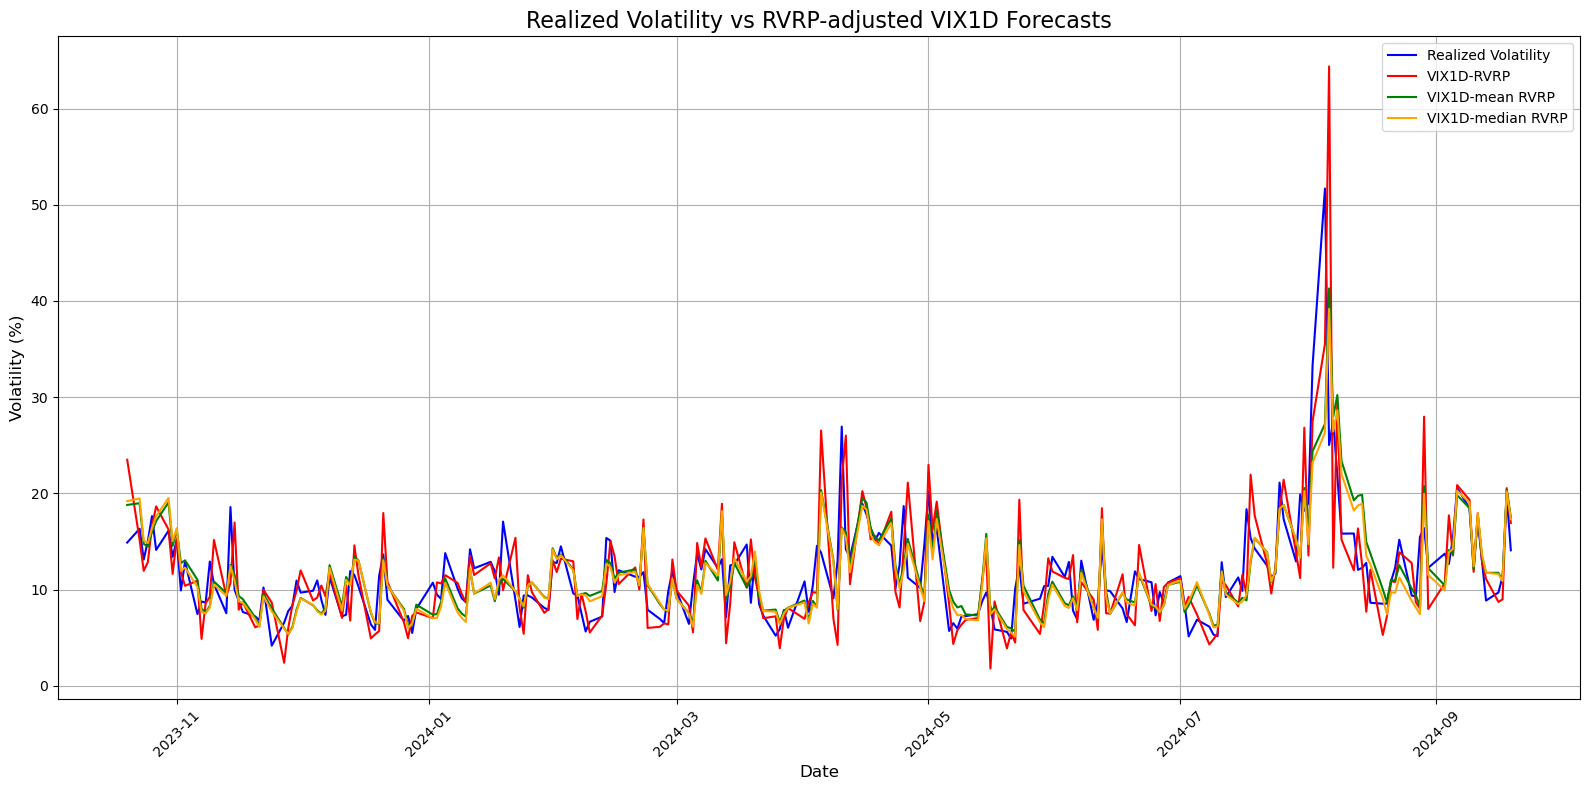


Metrics for VIX1D_RVRP:
MSE: 21.0694
MAE: 2.8532
MAPE: 24.31%

Metrics for VIX1D_mean_RVRP:
MSE: 11.7425
MAE: 2.2883
MAPE: 19.98%

Metrics for VIX1D_median_RVRP:
MSE: 11.5254
MAE: 2.2836
MAPE: 19.71%


In [7]:
# Calculate RVRP
merged_data['RVRP'] = merged_data['vix1d'].shift(1) - merged_data['realized_volatility']

# Calculate RVRP-adjusted VIX1D forecasts
merged_data['VIX1D_RVRP'] = merged_data['vix1d'].shift(1) - merged_data['RVRP'].shift(1)
merged_data['VIX1D_mean_RVRP'] = merged_data['vix1d'].shift(1) - merged_data['RVRP'].rolling(window=21).mean().shift(1)
merged_data['VIX1D_median_RVRP'] = merged_data['vix1d'].shift(1) - merged_data['RVRP'].rolling(window=21).median().shift(1)

# Remove rows with NaN values
merged_data_clean = merged_data.dropna()

# Create the plot
plt.figure(figsize=(16, 8))
plt.plot(merged_data_clean.index, merged_data_clean['realized_volatility'], label='Realized Volatility', color='blue')
plt.plot(merged_data_clean.index, merged_data_clean['VIX1D_RVRP'], label='VIX1D-RVRP', color='red')
plt.plot(merged_data_clean.index, merged_data_clean['VIX1D_mean_RVRP'], label='VIX1D-mean RVRP', color='green')
plt.plot(merged_data_clean.index, merged_data_clean['VIX1D_median_RVRP'], label='VIX1D-median RVRP', color='orange')

plt.title("Realized Volatility vs RVRP-adjusted VIX1D Forecasts", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility (%)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate MSE, MAE, and MAPE for each forecast
for forecast in ['VIX1D_RVRP', 'VIX1D_mean_RVRP', 'VIX1D_median_RVRP']:
    mse = mean_squared_error(merged_data_clean['realized_volatility'], merged_data_clean[forecast])
    mae = mean_absolute_error(merged_data_clean['realized_volatility'], merged_data_clean[forecast])
    mape = np.mean(np.abs((merged_data_clean['realized_volatility'] - merged_data_clean[forecast]) / merged_data_clean['realized_volatility'])) * 100
    
    print(f"\nMetrics for {forecast}:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")